In [69]:
import os
from operator import add
from typing_extensions import TypedDict, Annotated
import yaml
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import AnyMessage, add_messages
import openai

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

In [67]:
with open("prompts.yaml", "r") as file:
    PROMPTS = yaml.safe_load(file)

In [54]:
class Task(TypedDict):
    """Represent a task, i.e. a general subproblem of the user's prompt which needs to be solved."""
    
    name: Annotated[str, "The name of the task."]
    description: Annotated[str, "The description of the task."]
    expected_output: Annotated[str, "The expected output or contribution of the task."]


class InputState(TypedDict):
    input_problem: str
    task_history: list[Task]
    task: Annotated[Task, "The current task to solve."]


class OutputState(TypedDict):
    solution: Annotated[str | None, "The solution to the current task."] = None
    recommendation: Annotated[str | None, "A recommendation for the process router."] = None
    partial_solution: Annotated[str | None, "A partial solution to the current task if the task is not yet solved."] = None


class SchemaState(InputState, OutputState):
    messages: Annotated[list[AnyMessage], add_messages] = []

In [51]:
class SchemaSetup:
    def __call__(self, state: InputState) -> SchemaState:
        prompt_template = SystemMessagePromptTemplate.from_template(template=PROMPTS["system_prompt"])
        prompt_template = prompt_template.format_messages(input_problem=state["input_problem"], task_history=state["task_history"], task=state["task"])[0]
        setattr(prompt_template, "source_node", self.__class__.__name__)
        return {
            "messages": [prompt_template]
        }

In [50]:
class Cognition:
    def __init__(self):
        self.cognition_llm = ChatOpenAI(model="gpt-4o", top_p=0.8)
        self.refine_cognition_llm = ChatOpenAI(model="gpt-4o", temperature=0.4)
        self.refine_counter = 0

    def __call__(self, state: SchemaState) -> SchemaState:
        if getattr(state["messages"][-1], "source_node", None) == "SchemaSetup":
            return self.first_round_cognition(state)
        else:
            self.refine_counter += 1
            raise NotImplementedError

    def first_round_cognition(self, state: SchemaState) -> SchemaState:
        ai_message = self.cognition_llm.invoke(state["messages"])
        setattr(ai_message, "source_node", self.__class__.__name__)
        return {
            "messages": [ai_message]
        }

    def refine_cognition(self, state: SchemaState) -> SchemaState:
        pass

In [ ]:
class PartialEvaluation:
    def __init__(self) -> None:
        self.partial_evaluation_llm = ChatOpenAI(model="gpt-4o", temperature=0.5, stop_sequences=["<</STOP>>"])

    def __call__(self, state: SchemaState) -> SchemaState:
        context = state["messages"] + [HumanMessage(PROMPTS["evaluation_prompt"], source_node=self.__class__.__name__)]
        ai_message = self.partial_evaluation_llm.invoke(context)
        setattr(ai_message, "source_node", self.__class__.__name__)
        setattr(ai_message, "is_ok", ai_message.content.endswith("<<OK>>"))
        return {
            "messages": [ai_message]
        }

In [74]:
setup = SchemaSetup()
cognition = Cognition()
evaluation = PartialEvaluation()

graph = StateGraph(SchemaState, input=InputState, output=OutputState)
graph.add_node("setup", setup)
graph.add_node("cognition", cognition)
graph.add_node("partial_evaluation", evaluation)
graph.add_edge(START, "setup")
graph.add_edge("setup", "cognition")
graph.add_edge("cognition", "partial_evaluation")
graph.add_conditional_edges("partial_evaluation", lambda state: getattr(state["messages"][-1], "is_ok", False), {True: END, False: "cognition"})
graph = graph.compile()

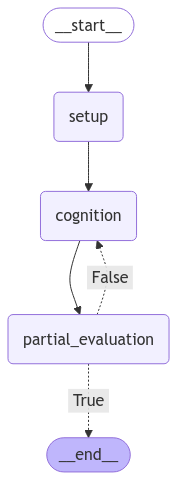

In [75]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [66]:
graph.invoke({"input_problem": "I want to build a website.", "task_history": [], "task": {"name": "Create a website", "description": "Create a website for my business.", "expected_output": "A website for my business."}})